In [1]:
# IMPORTS

import random
from neuron import h, gui
from neuron.units import ms, mV, um, V, cm
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm

from time import time
import os.path

from socket import gethostname

%config InlineBackend.figure_formats = ['svg']

h.load_file('model-files/basal_project.hoc')

1.0

In [2]:
# BARDIA CELL INITIATION (ALTERED)

ratio=0
loc=10
nsyn=0
sec=h.a1_111

dendrec=True

print(f'\n%s .... Starting Run' % (gethostname()))
iotim = 0
tic = time()

h.synrec = 1

h.tsamp = h.tstop/h.dt+1
h.synrec = 1
tsamp = int(h.tsamp)

r = h.Random(h.luckyoffset)
r.negexp(h.meanisi)

# h.a1_111.nseg = int(np.floor(h.a1_111.L))
# h.a1_111.nseg = int(np.floor(h.a1_111.L)/2)
seclist = [h.a1_111,
           h.a9_122,
           h.a10_11,
           h.a5_1,
           h.a8_11,
           h.a3_11,
           h.a9_122,
           h.a9_121,
           h.a8_122,
           h.a8_121,
           h.a7_111]

sl2 = h.SectionList()
for sec in seclist:
    sl2.append(sec = sec)
poppedsecs = sl2.unique()
h.refreshnseg(h.makeactivelist(sl2))
print(f'nseg: %d' % (h.nsegcnt()))
h.cvode.cache_efficient(1)
h.cvode_active(0)
h.poisson = 0


Christophers-MacBook-Pro.local .... Starting Run
nseg: 787


In [3]:
######################### BIOPHYSICAL FUNCTIONS #########################

def add_spines(branches):
    
    """
    Adds spines to all branches within the branch list
    5 spines per segment on each branch
    
    Returns nested list of spines within each branch 
    """
    
    # Intialize vectors for the spine head/neck
    spine_head = []
    spine_neck = []
    
    # Iterates through the number of branches of interest (list)
    num_branch = len(branches)
    for j in range(num_branch):
        
        
        # branches[j].nseg = int((np.floor(branches[j].L)) / 4)
        spine_head_temp = []
        spine_neck_temp = []

        # Number of spines: 5 per segment
        n_spines = branches[j].nseg * 5

        # Iterate through the number of spines for the particular branch
        for i in range(n_spines):
            
            # Create head and neck biophysical parameters
            spine_head_temp.append(h.Section())
            spine_neck_temp.append(h.Section())

            spine_head_temp[-1].L = 0.5
            spine_head_temp[-1].diam = 0.5
            spine_head_temp[-1].Ra = 100
            spine_head_temp[-1].insert('pas')
            for seg in spine_head_temp[-1]:
                seg.pas.e = -70
                seg.pas.g = 0.00005

            spine_neck_temp[-1].L = 1.5
            spine_neck_temp[-1].diam = 0.25
            spine_neck_temp[-1].Ra = 100
            spine_neck_temp[-1].insert('pas')
            for seg in spine_neck_temp[-1]:
                seg.pas.e = -70
                seg.pas.g = 0.00005
    
            # Connect head and neck together; then connect neck to branch
            spine_neck_temp[-1].connect(branches[j]((i+1)/n_spines))
            spine_head_temp[-1].connect(spine_neck_temp[-1])
        
        
        spine_head.append(spine_neck_temp)
        spine_neck.append(spine_head_temp)
    
    return spine_neck, spine_head

def add_inhib_soma(num):
    """
    Adds GABA synapses to the soma
    num: number of synapses
    
    Returns list of GABA synapses on the soma

    """

    syn_gaba_soma = []
    for i in range(num):
        syn_gaba_soma.append(h.GABAa_S(h.soma(0.5)))
        
    return syn_gaba_soma
    
def add_syn(branches, inhib=False):
    
    """
    Adds AMPA, NMDA, and GABA synaptic channels to a list of branches
    branches: list of branches
    inhib: boolean, determines if inhibitory synapses will be added to the branches
    
    Returns three nested vectors containing the synapses
    """

    syn_ampa = []
    syn_nmda = []
    syn_gaba = []
    
    num_branch = len(branches)
    
    # Iterates through the number of branches and applies synapses to every spine
    for j in range(num_branch):
        
        syn_ampa_temp = []
        syn_nmda_temp = []
        syn_gaba_temp = []
        
        # Indexes spine heads of the current branch
        n_spines = len(spine_head[j])
        for i in range(n_spines):
            
            # adds AMPA, NMDA, and GABA synapses to each spine
            syn_ampa_temp.append(h.Exp2Syn(spine_head[j][i](0.5)))
            syn_nmda_temp.append(h.Exp2SynNMDA(spine_head[j][i](0.5)))
            syn_ampa_temp[-1].e = 0
            syn_ampa_temp[-1].tau1 = 0.05
            syn_ampa_temp[-1].tau2 = 0.5
            syn_nmda_temp[-1].e = 0
            syn_nmda_temp[-1].tau1 = 2.1
            syn_nmda_temp[-1].tau2 = 18.8
            
            if inhib:
                syn_gaba_temp.append(h.GABAa_S(spine_head[j][i](0.5)))
            
        syn_ampa.append(syn_ampa_temp)
        syn_nmda.append(syn_nmda_temp)
        syn_gaba.append(syn_gaba_temp)
    
    return syn_ampa, syn_nmda, syn_gaba

######################### CURRENT INJECTIONS ############################

def frequency_counter(t_vec, v_vec):
    """
    Returns the frequency of spikes measured at the soma
    
    t_vec: time vector
    v_vec: voltage vector
    
    """
    
    # Chops off the first 100ms, in which the model is still reaching steady-state
    t_tot = t_vec[-1]
    start_t_i = np.where(np.floor(t_vec)==100)[0][0]
    
    spike_counter = 0
    length_v = len(v_vec)
    
    # Iterates from 100ms to end of time for the vector; calculates spikes
    for i in range(start_t_i, length_v-1):
        if v_vec[i] < 0 and v_vec[i+1] >= 0:
            spike_counter += 1
    
    # Determines the frequency of spikes
    frequency = (spike_counter/(t_tot-100)) * 10 ** 3
    
    return frequency


def fi_curve(adj,
             adj_var,
             max_c, 
             inc, 
             avg,
             n_gaba,
             g,
             firing,
             dtb, 
             dendrite_gaba = False, 
             distance = 0.5):
    
    """
    Generates an FI curve through injecting increasing current into the soma
    max_c: the maximum amount of injected current at the soma (nA)
    inc: the size step of the amount of current (nA)
    avg: the number of times each FI point will be averaged along the curve
    g: conductance of GABA synapses
    dtb: distribution of GABA synpse firing
    """
    
    h.tstop = 600 # ms
    h.v_init = -70 # mV
    
    frequency_list = []
    
    # Iterates through increasing current injections
    for amp in tqdm(np.linspace(0, max_c, int(max_c/inc + 1))):
        
        f_trial = []
        
        # Performs averaged trials at a specific current value
        for j in range(avg):

            adjust, stim_obj, current, tt = current_injection(amp=adj, var=adj_var)

            
            # Creates a background GABA stimulus
            ncstim_ = None
            ncstim_, syn_stim_gaba = background_simulation(basal_dendrites,
                                                           n_gaba,
                                                           g,
                                                           firing,
                                                           dtb,
                                                           dendrite_gaba,
                                                           distance)
            
            
            # Creates current injection
            temp = []
            temp = h.IClamp(h.soma(1))
            temp.delay = 0
            temp.dur = 1e9
            temp.amp = amp
            
            # Calculates voltage trace
            soma_v = h.Vector().record(h.soma(1)._ref_v)
            t_vec = h.Vector().record(h._ref_t)
            h.finitialize()
            h.run()

            
            f_trial.append(frequency_counter(t_vec, soma_v))
            temp = None
            ncstim_ = None
            syn_stim_gaba = None

            adjust = None
            stim_obj = None
            current = None
            tt = None
        
        frequency = np.mean(np.array(f_trial))
        frequency_list.append(frequency)
    
    amp_list = np.linspace(0, max_c, int(max_c/inc + 1))

    return amp_list, frequency_list

##################### SYNAPSE BEHAVIOR ##########################

def background_simulation(branches, 
                          n_gaba,
                          g,
                          firing=50,
                          dtb=3,
                          dendrite_gaba=False,
                          distance=0.5):
    
    """
    Simulates background synapses along basal dendrites,
    in which the soma has basket cell-like inhibitory synapses
    
    Firing rate is fixed to 5 Hz with a Guassian distribution of start times
    
    branches: list of branches
    n_gaba: number of GABA synapses at the soma
    g: conductance of GABA synapses (µS)
    firing: firing rate of GABA-gamma synapses [50 Hz default]
    dtb: std of distribution for firing rates [Hz]
    dendrite_gaba: determines if GABA synapses are added to the basal dendrites
    distance: determines the distance GABA synapses are added to basal dendrites (can be decimal or exact value)
    """
    
    # GABA Stimulations; all fire at 5 Hz (no noise) at Gaussian-distributed start times
    syn_stim_gaba = []
    
    # Determine interval between GABA synapses (dt)
    interval_gaba = 1000/firing
    
    # Calculates number of times GABA fires within time period
    num_firing = int(np.floor(h.tstop/interval_gaba))

    # Iterates through GABA firing
    for i in range(num_firing+1):
        
        # For each synapse, generates distribution of firing for each time point
        gaba_start_distribution = np.random.normal(0, dtb, n_gaba)

        # Iterate through all firing instances for each synapse
        for j in range(n_gaba):
            syn_stim_gaba.append(create_stim(interval=interval_gaba,
                                                      num=1,
                                                      start=gaba_start_distribution[j]+interval_gaba*i,
                                                      noise=0,
                                                      s=1))
    
    
    num_branch = len(branches)
    ncstim=[]
    
    # Iterate through GABA firing periods
    for q in range(num_firing+1):
        
        n_s = 0 # Number of synapses
        c = 0   # Spread of repeated branch synapses
        i = 1   # Index of branches
        
        # Iterate through the number of synapses, then shift the firing period
        while n_s < n_gaba:
            
            # Place stimulus at x distance along dendrite of the way along the basal dendrite
            branch_i = branches[i]
            branch_nseg = branch_i.nseg
            
            # If distance is > 1, find the nseg that is the absolute distance
            if distance > 1:
                
                s_f_s = h.distance(h.soma(1), branch_i(0))
                loc = int(np.floor((distance - s_f_s)/branch_i.L)*len(syn_gaba[i]))
                
            # If distance is a decimal, calculate the percentage along the dendrite
            else:
                loc = int(np.floor(distance * branch_nseg))
            
            # Append firing instances to SOMA GABA synapses
            ncstim.append(h.NetCon(syn_stim_gaba[n_s+q*n_gaba], syn_gaba_soma[n_s], 0, 0, g))
            n_s += 1
            
            # For when GABA syns are applied to branches
            if dendrite_gaba:
                
                # Append firing instances to BASAL DENDRITE GABA synapses
                i += 1
                ncstim.append(h.NetCon(syn_stim_gaba[n_s], syn_gaba[i][loc+c], 0, 0, g))
            
            # Reinitialize branch index to first branch, increase branch spread by one
            if i == num_branch - 1:
                i = 1
                c = c + 1
    

    return ncstim, syn_stim_gaba


def create_stim(interval=10, num=3, start=5, noise=0, s=1):
    
    """
    Creates a stimulator object used as the pre-synaptic stimulus
    interval: amount of time between stimulation events (ms)
    num: the number of stimulation events
    start: delay of stimulation (ms)
    s: seed number
    """
    
    stim = h.NetStim()
    stim.interval = interval
    stim.number = num
    stim.start = start
    stim.noise = noise

    if s == 1:
        stim.seed(np.random.randint(1000000))
    else:
        stim.seed(s)
    
    return stim

def increase_syn(branch, 
                 loc, 
                 n_syn, 
                 stim, 
                 g, 
                 spread,
                 distribute,
                 adj,
                 adj_var=0,
                 avg=1,
                 n_gaba=40,
                 g_bg=0,
                 firing=50,
                 dtb=3,
                 dendrite_gaba=False,
                 distance=0.5,
                 stim_spread=0,
                 sync=True,
                 plot=True,
                 progress_bar=False):
    
    """
    IO curve that measures somatic response with signal NMDA+AMPA synapses under a
    number of parameters for signal input with SYNAPTIC NOISY BACKGROUND (FS CURVE)
    
    branch: branch being stimulated (h.XXXXX)
    loc: fraction of distance from end to end of the dendrite
    n_syn: total number of synapses being added to the dendrite
    g: conductance of signal synapses; [AMPA, NMDA]
    spread: spread of signal synapses, spatially (by index number)
    avg: number of trials being run
    n_gaba: number of GABA synapses
    g_bg: conductance of background synapses [gaba, theta_ampa, theta_nmda, gamma_ampa, gamma_nmda]
    firing: frequency of background synapses [gaba, theta, gamma] [Hz]
    dtb: distribution of theta rythms (variance of curves)
    dendrite_gaba: determines if GABA synapses are added to the basal dendrites
    distance: determines the distance GABA synapses are added to basal dendrites (can be decimal or exact value)
    stim_spread: staggers start times of each synapse by ___ ms
    sync: synchronizes all synapses (BOOLEAN)
    plot: plots the voltage traces for each FS curve along with the FS curve
    progress_bar: boolean, determines if there should be a progress bar for EACH trial
    """
    
    # Output the location at whoch the stimulus branch is being acted on
    loc_n = int(np.floor(len(syn_ampa[0])*loc))
    loc_um = int(np.floor(branch.L*loc))
    print('Applying synapses at ~' + str(loc_um) + ' µm (' + str(branch.L) + ' µm total)')
    
    f_vec = np.zeros((1, n_syn+1), dtype=float)
    
    # Plot for voltage traces; only useful if avg=1
    if plot:
        plt.figure(figsize=(10, 8))
    
    
    # Iterate through the averaging number
    for j in tqdm(range(avg)):
        
        # Increase size of frequency vector
        if j > 0:
            f_vec = np.vstack([f_vec, np.zeros((1, n_syn+1), dtype=float)])
        
        h.v_init = -70
    
        ncstim = []
        f = []
        syn_stims = []
        
        # If SYNC, all excitatory stimulus are the same
        if sync:
            syn_stims.append(create_stim(interval=stim[0],
                                         num=stim[1],
                                         start=stim[2],
                                         noise=stim[3],
                                         s=stim[4]))
        
        # If synapses are not synced, each synapse gets its own stimulus object
        else:
            for q in range(n_syn):
                syn_stims.append(create_stim(interval=stim[0],
                                             num=stim[1],
                                             start=stim[2]+q*stim_spread,
                                             noise=stim[3],
                                             s=stim[4]))
        
        # Iterate through the number of synapses (0 to n_syn)
        for i in tqdm(range(n_syn+1), disable=not(progress_bar)):

            adjust, stim_obj, current, tt = current_injection(amp=adj, var=adj_var)

            
            # Generate background GABA stimulus objects 
            y=i
            ncstim_ = None
            ncstim_, syn_stim_gaba = background_simulation(basal_dendrites,
                                                           n_gaba=n_gaba,
                                                           g=g_bg,
                                                           firing=firing,
                                                           dtb=dtb,
                                                           dendrite_gaba=dendrite_gaba,
                                                           distance=distance)
            
            # For non-zero excitatory synapses
            if y != 0:
                
                
                if sync:
                    y=0

                if distribute:
                    loc_n = np.floor(random.random() * len(syn_ampa[0]))
        
                # Apply stimulus to excitatory dendrite synapse (increasing the # of synapses)
                ncstim.append(h.NetCon(syn_stims[y-1], syn_ampa[0][loc_n+spread*i], 0, 0, g[0]))
                ncstim.append(h.NetCon(syn_stims[y-1], syn_nmda[0][loc_n+spread*i], 0, 0, g[1])) # gMax

            soma_v = h.Vector().record(h.soma(0.5)._ref_v)
            t_vec = h.Vector().record(h._ref_t)

            h.finitialize()
            h.run()
            if plot:
                plt.plot(t_vec, soma_v, label=str(i+1))

            f.append(frequency_counter(t_vec, soma_v))

            current = None
            i_c = None
            stim_obj = None
            ncstim_= None
            syn_stim_gaba = None

            adjust = None
            stim_obj = None
            current = None
            tt = None

        f_vec[-1, :] = f
    
    # AVERAGES RUN DATA
    f = f_vec.mean(axis=0)
    
    if plot:
        plt.legend()
        plt.xlabel('Time (ms)')
        plt.ylabel('Somatic Voltage (mV)')
        plt.title('Increasing Number of Synapses')
        plt.figure(figsize=(12, 8))
        plt.plot(f_vec.mean(axis=0))
        plt.title('FS Curve')
        plt.xlabel('# of Synapses')
        plt.ylabel('Somatic Frequency (Hz)')
    
    ncstim = None
    syn_stim = None
    
    return f

def apply_syn_cluster(branch,
                      measure,
                      loc,
                      n_syn,
                      stim_obj,
                      g,
                      spread,
                      distribute=False,
                      sync=False,
                      stim_spread=0,
                      plot=True,
                      xlim=1,
                      ylim=1):
    
    """
    Applies a number of synapses at a specified location, giving a stimulus object
    Can be used to look at voltage traces of synapses, typically with a background current
    
    branch: branch being activated
    measure: branch(loc) where voltage is recorded from
    loc: location of applied synapses along dendrite (decimal)
    n_syn: number of synapses being applied to branch
    stim_obj: stimulation parameters
    g: conductance of AMPA/NMDA
    spread: how far apart synapses are (index based)
    sync: determines whether all synapses fire synchronously
    stim_spread: temporal shift between each synapse
    """
    
    # Output the location of stimulus
    loc_n = int(np.floor(len(syn_ampa[0])*loc))
    loc_um = int(np.floor(branch.L*loc))
    print('Applying synapses at ~' + str(loc_um) + ' um (' + str(branch.L) + ' um total)')
    
    ncstim1 = []
    syn_stims1 = []
    
    # If synchronous, only one stimulus object is created for ALL synapses
    if sync:
        syn_stims1.append(create_stim(interval=stim_obj[0],
                                         num=stim_obj[1],
                                         start=stim_obj[2],
                                         noise=stim_obj[3],
                                         s=stim_obj[4]))
    
    # If not synchronous, all synapses recieve their own stim object
    else:
        for i in range(n_syn):
            syn_stims1.append(create_stim(interval=stim_obj[0],
                                         num=stim_obj[1],
                                         start=stim_obj[2]+stim_spread*i,
                                         noise=stim_obj[3],
                                         s=stim_obj[4]))
 
    
    if plot:
        plt.figure(figsize=(10, 8))
    
    # Applies synapses
    if n_syn != 0:
        for i in tqdm(range(n_syn)):
            j=i
            if sync:
                j=0

            if distribute:
                loc_n = np.floor(random.random() * len(syn_ampa[0]))
                
            ncstim1.append(h.NetCon(syn_stims1[j], syn_ampa[0][loc_n+spread*i], 0, 0, g[0]))
            ncstim1.append(h.NetCon(syn_stims1[j], syn_nmda[0][loc_n+spread*i], 0, 0, g[1])) # gMax
    
    # Calculates voltage trace
    soma_v = h.Vector().record(measure._ref_v)
    t_vec = h.Vector().record(h._ref_t)
    h.finitialize()
    h.run()
    
    # Plotes resulting voltage trace
    if plot:
        plt.plot(t_vec, soma_v)
     
    # Outputs the resulting frequency
    f = frequency_counter(t_vec, soma_v)
    print("Frequency: " + str(f) + " Hz")
    
    
    # Plot modifications (one can modify the x and y lim values)
    plt.legend()
    plt.xlabel('Time (ms)')
    if xlim != 1:
        plt.xlim(xlim[0], xlim[1])
    if ylim != 1:   
        plt.ylim(ylim[0], ylim[1])
    plt.ylabel('Somatic Voltage (mV)')
    plt.title('Voltage Trace')
    
    ncstim1 = None
    syn_stims1 = None
    
    return f, soma_v, t_vec

def background_rate(avg, 
                    n_g,
                    g,
                    firing=50,
                    dtb=3,
                    dendrite_gaba=False,
                    distance=0.5,
                    plot=False, 
                    xlim=1, 
                    ylim=1):

    """
    
    Returns the firing rate with ONLY background current injection (injected at the soma)
    Noisy current created using mean and variance parameters
    Optional: plots the trace at the soma
    
    avg: Number of trials being averages
    g: conductance of GABA synapses
    n_g: Number of GABA synapses placed
    firing: firing rate of GABA-gamma synapses [50 Hz default]
    dtb: std of distribution for firing rates [Hz]
    dendrite_gaba: determines if GABA synapses are added to the basal dendrites
    distance: determines the distance GABA synapses are added to basal dendrites (can be decimal or exact value)
    
    """
    
    h.v_init = -70
    h.tstop = 1000
    
    freq = []
    
    # Iterate through each averaging trial
    for q in tqdm(range(avg)):
        
        # Apply background synapses
        ncstim_, syn_stim_gaba = background_simulation(branches=basal_dendrites, 
                                                       n_gaba=n_g,
                                                       g=g,
                                                       firing=firing,
                                                       dtb=dtb,
                                                       dendrite_gaba=dendrite_gaba,
                                                       distance=distance)
        
        # Run simulation
        soma_v = h.Vector().record(h.soma(0.5)._ref_v)
        t_vec = h.Vector().record(h._ref_t)
        h.finitialize()
        h.run()
    
        # Calculate background rate
        freq.append(frequency_counter(t_vec, soma_v))
        ncstim_ = None
    
    # Plot the resulting voltage trace
    if plot:
        plt.plot(t_vec, soma_v)
        plt.title('Voltage Trace of Noisy Current')
        plt.xlabel('Time (ms)')
        plt.ylabel('Somatic Voltage (mV)')
        if xlim != 1:
            plt.xlim(xlim[0], xlim[1])
        if ylim != 1:
            plt.ylim(ylim[0], ylim[1])
    
    # Output the mean rate
    mean_rate = float(np.mean(freq))
    print('The average background firing rate is ', str(mean_rate) + ' Hz')
    
    ncstim_ = None
    syn_stim_gaba = None
    
    return np.mean(freq)

def steady_gaba_conductance(g):
    steady_synapse = h.GABAa_S(h.soma(0.5))
    syn_stim_steady = create_stim(interval=0,
                                    num=1e9,
                                    start=0,
                                    noise=0,
                                s=2)
    ncstim_steady = (h.NetCon(syn_stim_steady, steady_synapse, 0, 0, g))
    return ncstim_steady, steady_synapse, syn_stim_steady
    

def poisson_syn_weight(branch, start=30):
    """
    n_syn: Number of syns being simulated
    branch: Branch being simulated
    start: point at which the synapses can start to attach (µm)
    """
    
    n_syn = 1
    incorrect_num = True
    while incorrect_num:

        n_bins_fix = int(np.floor(  (start/branch.L)*branch.nseg ))

        nbins = branch.nseg - n_bins_fix
        prob_vec = np.linspace(3, 1, nbins)
        sum_prob = np.sum(prob_vec)
        prob_of_syn = n_syn*prob_vec/sum_prob

        syns = np.random.rand(nbins) < prob_of_syn
        syns = syns * 1
        no_syns_region = np.zeros(n_bins_fix)
        syns = np.concatenate((no_syns_region, syns), axis=0)

        num_events = np.sum(syns)
        if num_events == int(n_syn):
            incorrect_num = False
    
    ln_syns = len(list(syns))

    index = list(syns).index(1)
    syn_loc = index/ln_syns
        
    return syn_loc

def current_injection(amp, var):
    tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
    current = np.random.normal(amp, var, len(tt))
    
    adjust = h.Vector()
    adjust.from_python(current)
    stim_obj = h.IClamp(h.soma(0.5))
    stim_obj.delay = 0  # ms
    stim_obj.dur = 1e9  # ms
    adjust.play(stim_obj._ref_amp, tt, True)
    return adjust, stim_obj, current, tt
    

In [4]:
basal_dendrites = [h.a1_111,
                   h.a9_122,
                   h.a10_11,
                   h.a5_1,
                   h.a8_11,
                   h.a3_11,
                   h.a9_122,
                   h.a9_121,
                   h.a8_122,
                   h.a8_121,
                   h.a7_111]

In [5]:
n_gaba = 30

spine_neck, spine_head = add_spines(basal_dendrites)
syn_ampa, syn_nmda, syn_gaba = add_syn(basal_dendrites, inhib=True)
syn_gaba_soma = add_inhib_soma(n_gaba)

In [6]:
h.distance(h.soma(1), h.a1_111(0.5)) 

138.671320953448

In [7]:
h.a1_111.L

243.8985804846295

In [36]:
h.GABAa_S(h.soma(0.5)).g

0.0

  0%|          | 0/20 [00:00<?, ?it/s]

The average background firing rate is  111.83333333337828 Hz


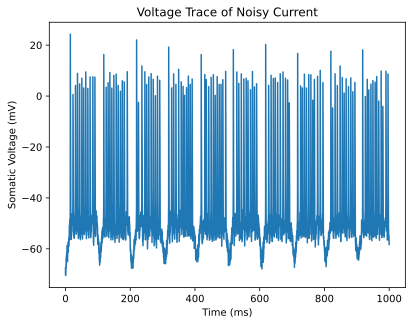

In [37]:
# DETERMINE BACKGROUND RATE OF SYNAPTIC BACKGROUND #
adjust, stim_obj, current, tt = current_injection(amp=2.3, var=2)

background_rate(avg=20, 
                n_g=30,
                g=0.01,
                firing=10,
                dtb=3,
                dendrite_gaba=False,
                distance=139,
                plot=True)

adjust = None
stim_obj = None
current = None
tt = None

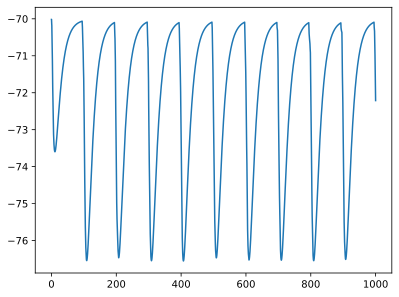

In [10]:
# VOLTAGE TRACE FOR BACKGROUND SYNAPTIC INPUT ONLY

h.tstop = 1000

# NOTE: MUST CLEAR NCSTIM_, otherwise, there is OVERLAP!
ncstim_ = None
np.random.seed(1)
ncstim_ = background_simulation(basal_dendrites,
                                n_gaba=30,
                                g=0.005,
                                firing=10,
                                dtb=3,
                                dendrite_gaba=False,
                                distance=0.5)

soma_v = h.Vector().record(h.soma(0.7)._ref_v)
t_vec = h.Vector().record(h._ref_t)
        
h.finitialize()
h.run()

plt.plot(t_vec, soma_v)

ncstim_ = None

In [32]:
import time

start_time = time.time()

# Chops off the first 100ms, in which the model is still reaching steady-state
t_tot = t_vec[-1]
start_t_i = np.where(np.floor(t_vec)==100)[0][0]

spike_counter = 0
length_v = len(soma_v)

# Iterates from 100ms to end of time for the vector; calculates spikes
for i in range(start_t_i, length_v-1):
    if soma_v[i] < 0 and soma_v[i+1] >= 0:
        spike_counter += 1
end_time = time.time()
print(end_time-start_time)

0.004550933837890625


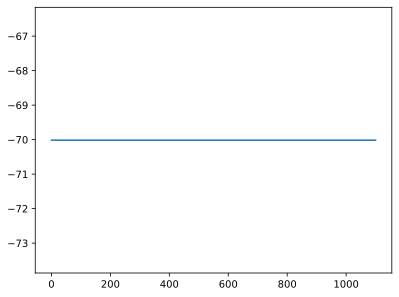

In [40]:
# PLOT OF RESTING CELL (CHECK FOR REMAINING STIMULUS OBJECTS):

ncstim_ = None
soma_v = h.Vector().record(h.soma(0.7)._ref_v)
t_vec = h.Vector().record(h._ref_t)
        
h.finitialize()
h.run()

plt.plot(t_vec, soma_v)

Applying synapses at ~121 um (243.8985804846295 um total)


  0%|          | 0/40 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Frequency: 10.000000000004528 Hz


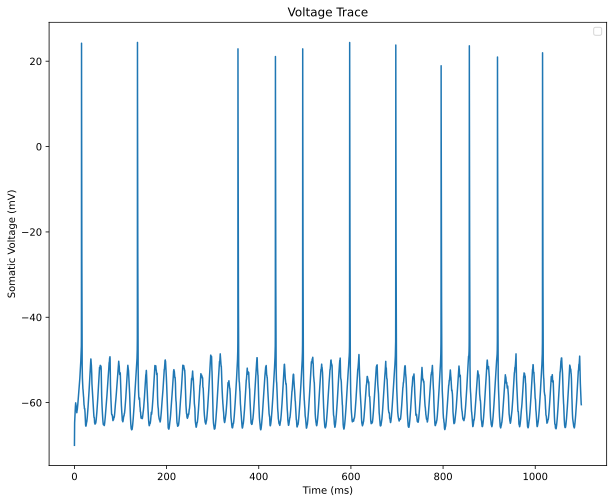

In [63]:
############ TESTING ############

# NOTE: MUST CLEAR NCSTIM_, otherwise, there is OVERLAP!
ncstim_ = None

# Apply background stimulus
ncstim_, syn_stim_gaba = background_simulation(basal_dendrites,
                                               n_gaba=30,
                                               g=0.015,
                                               firing=50,
                                               dtb=3,
                                               dendrite_gaba=False,
                                               distance=0.5)

# Apply constant current injection
# adjust = h.IClamp(h.soma(1))
# adjust.delay = 0
# adjust.dur = 1e9
# adjust.amp = 1.875

# Apply steady inhibitory conductance
# ncstim_steady, steady_synapse, syn_stim_steady = steady_gaba_conductance(g=0.04)

# # Apply sinusoidal current injection
# xx = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
# t = np.linspace(0, h.tstop, int(h.tstop/h.dt))
# current_ = 1.9 + 0.5*np.sin(2*np.pi/20*t)
# i_c_ = h.Vector()
# i_c_.from_python(current_)
# stim_obj_ = h.IClamp(h.soma(0.5))
# stim_obj_.delay = 0  # ms
# stim_obj_.dur = 1e9  # ms
# i_c_.play(stim_obj_._ref_amp, xx, True)

# np.random.seed(1)
# Apply noisy current injection
adjust, stim_obj, current, tt = current_injection(amp=3.125, var=0)

# Apply synapses and analyze voltage traces
h.tstop = 1100

# Number of synapses being applied to the cell
num_s = 40

# stim_param = [interval, num, start, noise, seed]
stim_param =   [1000/50,  1e9,   5,     0,     2]

f, volt, time = apply_syn_cluster(branch=h.a1_111,
                                  measure=h.soma(0.5),
                                  loc=0.5,       
                                  n_syn=num_s,
                                  stim_obj=stim_param,
                                  g=[0.0015, 0.0039],
                                  spread=0,
                                  sync=True,
                                  stim_spread=0,
                                  plot=True,
                                  xlim=1,
                                  ylim=1)

adjust = None
tt = None
xx = None
current = None
current_ = None
i_c = None
i_c_ = None
stim_obj = None
stim_obj_ = None
ncstim_ = None
tt = None
syn_stim_gaba = None

ncstim_steady = None
steady_synapse = None

In [64]:
# SAVE VOLTAGE TRACE

np.savetxt('SLURM-jobs/variable-inhibition/voltage-traces/variable-inhibition-voltage-trace-15-40.csv', np.vstack((time, volt)).T, delimiter=', ')

In [8]:
## FI CURVE (THETA BACKGROUND)

# NOTE: MUST CLEAR NCSTIM_, otherwise, there is OVERLAP!

# Apply sinusoidal current injection
# xx = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
# t = np.linspace(0, h.tstop, int(h.tstop/h.dt))
# current_ = 1.9 + 0.5*np.sin(2*np.pi/20*t)
# i_c_ = h.Vector()
# i_c_.from_python(current_)
# stim_obj_ = h.IClamp(h.soma(0.5))
# stim_obj_.delay = 0  # ms
# stim_obj_.dur = 1e9  # ms
# i_c_.play(stim_obj_._ref_amp, xx, True)

# ncstim_steady, steady_synapse, syn_stim_steady = steady_gaba_conductance(g=0.04)

i_1 = None
f_1 = None

i_1, f_1 = fi_curve(adj=0.75,
                    adj_var=1,
                    max_c=0.6,
                    inc=0.02,
                    avg=1,
                    n_gaba=1,
                    g=0.00,
                    firing=1,
                    dtb=3,
                    dendrite_gaba=False,
                    distance=139)


adjust = None
tt = None
xx = None
current = None
current_ = None
i_c = None
i_c_ = None
stim_obj = None
stim_obj_ = None
ncstim_ = None
tt = None
syn_stim_gaba = None

adjust = None
stim_obj = None
current = None
tt = None

ncstim_steady = None
steady_synapse = None
syn_stim_steady = None

  0%|          | 0/31 [00:00<?, ?it/s]

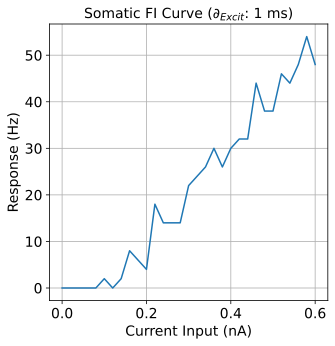

In [31]:
# FI CURVE PLOT
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
fig, axs_1 = plt.subplots(figsize=(5,5))
axs_1.plot(i_1, f_1)
axs_1.set_xlabel('Current Input (nA)', fontsize=14)
axs_1.set_ylabel('Response (Hz)', fontsize=14)
axs_1.set_title('Somatic FI Curve ($∂_{Excit}$: 1 ms)', fontsize=14)
axs_1.grid(visible=True, which='major')
# fig.savefig('FICurve.png', dpi=1000)
plt.show()

In [28]:
np.savetxt("variable-frequency-fi-100.csv", np.vstack((i_1, f_1)).T, delimiter=",")
# np.savetxt("FI_NOISY_freq.csv", f_2, delimiter=",")

In [9]:
# FS CURVE FOR GAMMA BACKGROUND #

# NOTE: FOR NONSYNCHRONOUS POISSION, SEED MUST BE 1

# stim_param = [interval, num, start, noise, seed]
stim_param =   [1000/75,  1e9,   5,     0,     1]

# Apply sinusoidal current injection
# xx = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
# t = np.linspace(0, h.tstop, int(h.tstop/h.dt))
# current_ = 1.9 + 0.5*np.sin(2*np.pi/20*t)
# i_c_ = h.Vector()
# i_c_.from_python(current_)
# stim_obj_ = h.IClamp(h.soma(0.5))
# stim_obj_.delay = 0  # ms
# stim_obj_.dur = 1e9  # ms
# i_c_.play(stim_obj_._ref_amp, xx, True)

# ncstim_steady, steady_synapse, syn_stim_steady = steady_gaba_conductance(g=0.04)

num_s = 40

f_2 = increase_syn(branch=h.a1_111, 
                   loc=0.5, 
                   n_syn=num_s,
                   stim=stim_param, 
                   g=[0.0015, 0.0039], 
                   spread=0,
                   distribute=False,
                   adj=2.56,
                   adj_var=0,
                   avg=25,
                   n_gaba=30,
                   g_bg=0.005,
                   firing=75,
                   dtb=2,
                   dendrite_gaba=False,
                   distance=139,
                   stim_spread=0,
                   sync=False,
                   plot=False,   
                   progress_bar=False)

adjust = None
tt = None
xx = None
current = None
current_ = None
i_c = None
i_c_ = None
stim_obj = None
stim_obj_ = None
ncstim_ = None
tt = None
syn_stim_gaba = None

adjust = None
syn_stim = None
current = None
tt = None
iclamp = None
stim = None
i_c = None
stim_obj = None
ncstim_ = None

ncstim_steady = None
steady_synapse = None
syn_stim_steady = None

Applying synapses at ~121 µm (243.8985804846295 µm total)


  0%|          | 0/25 [00:00<?, ?it/s]

Text(0, 0.5, 'Somatic Frequency (Hz)')

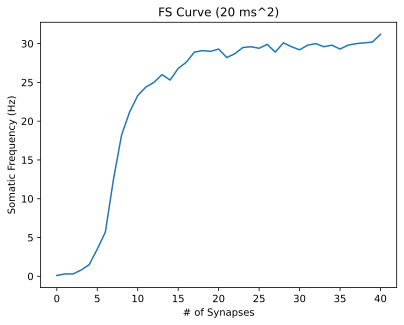

In [10]:
# PLOTTING FS CURVES 

plt.plot(f_2)
# plt.savefig('FSCurveThetaPoisson.svg')
plt.title('FS Curve (20 ms^2)')
plt.xlabel('# of Synapses')
plt.ylabel('Somatic Frequency (Hz)')

In [11]:
np.savetxt("variable-frequency-fs-75.csv", f_2, delimiter=",")